# Advanced Graph Analyses using the TERRA APIs

This notebook demonstrates how to perform advanced analytical workflows on TERRA data
that are **not directly available through the TERRA web dashboard**.

While the dashboard provides an interactive and exploratory view of international trade
networks, some analyses require:
- customized parameter settings,
- extended time ranges,
- or tailored post-processing steps.

To support these use cases, this notebook accesses TERRA data **directly via the official
TERRA APIs**, using a lightweight Python client (`terra_api`) and standard data
analysis tools.

The focus is on reproducibility and transparency: all data are retrieved programmatically
from the APIs and processed step by step within the notebook.


### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from terra_modules.terra_api import fetch_graph_time_range, fetch_graph_metrics

## Dataset and analysis parameters

This section defines the main parameters used to query the TERRA Graph API.

The analysis can be performed on different trade network configurations
(e.g. intra-EU or extra-EU trade) and at different temporal frequencies
(monthly or quarterly). Alternative configurations are reported in the cell
below and can be activated by uncommenting the relevant lines.

The base payload specifies the subset of trade flows and attributes to be
included in the graph construction, such as products, means of transport,
and flow direction.

### Reference classifications for graph parameters

Some parameters used in the graph queries (e.g. products and means of transport)
are based on predefined classifications exposed by the TERRA API.

The following endpoints can be used to explore the available categories and
identify valid values to be passed to the `BASE_PAYLOAD`:

- **Products (Extra-EU trade)**  
  https://api.terra.istat.it/cls/productsExtra?lang=en

- **Products (Intra-EU trade)**  
  https://api.terra.istat.it/cls/productsIntra?lang=en

- **Means of transport**  
  https://api.terra.istat.it/cls/transports?lang=en


In [2]:
# Dataset Graph EU - Extra EU
# dataset = "Extra"

# Dataset Graph EU - World
DATASET = "Intra"

# Monthly data  
FREQUENCY = "month"

# Quarterly data
# FREQUENCY = "quarter"

# Base payload
BASE_PAYLOAD = {
    "percentage": "50",
    "transport": [0, 1, 2, 3, 4, 5, 7, 8, 9], # means of transport
    "product": "TOT",
    "flow": 0, #import = 1, #export = 2
    "weight": True,
    "position": None,
    "edges": None,
    "collapse": True,
}

## Time range selection

The temporal coverage of the analysis is automatically retrieved from the
TERRA metadata service.

By default, the notebook loads the **maximum available time range** for graph
data. Users can optionally restrict the analysis to a narrower time window
by manually editing `start_date` and `end_date`, provided that the selected
interval lies within the available range.


In [3]:
# Retrieve available time range from the TERRA API
start_date, end_date = fetch_graph_time_range()

# Optional: set a custom time range within the available interval
start_date = "2021-01"
end_date = "2022-12"

start_date, end_date


Endpoint: https://api.terra.istat.it/cls/metadata
Graph time range: 2020-10 → 2025-09


('2021-01', '2022-12')

## Data retrieval from the TERRA Graph API

In this step, graph metrics are retrieved directly from the TERRA Graph API
using the parameters defined above.

The request is executed for each time period in the selected range, and the
resulting metrics are combined into a single tabular dataset, with one row per
country and time period.


## Structure of the graph metrics dataset

The retrieved graph metrics are stored in a tabular dataset with one row per
country and time period.

The main columns are:

- **country**: reporting country
- **period**: reference time period
- **density**: network density
- **degree**: total degree
- **in_degree**: number of incoming connections
- **out_degree**: number of outgoing connections
- **closeness**: closeness centrality
- **betweenness**: betweenness centrality
- **vulnerability**: vulnerability index
- **distinctiveness**: distinctiveness index


In [4]:
df_metrics = fetch_graph_metrics(
    dataset=DATASET,
    base_payload=BASE_PAYLOAD,
    start_date=start_date,
    end_date=end_date,
    frequency=FREQUENCY,
    verbose=True
)

Endpoint: https://api.terra.istat.it/graph/graphIntraMonth
Retrieving data for 202101
Retrieving data for 202102
Retrieving data for 202103
Retrieving data for 202104
Retrieving data for 202105
Retrieving data for 202106
Retrieving data for 202107
Retrieving data for 202108
Retrieving data for 202109
Retrieving data for 202110
Retrieving data for 202111
Retrieving data for 202112
Retrieving data for 202201
Retrieving data for 202202
Retrieving data for 202203
Retrieving data for 202204
Retrieving data for 202205
Retrieving data for 202206
Retrieving data for 202207
Retrieving data for 202208
Retrieving data for 202209
Retrieving data for 202210
Retrieving data for 202211
Retrieving data for 202212


In [5]:
df_metrics.head()

,country,density,degree,vulnerability,out_degree,closeness,betweenness,in_degree,distinctiveness,period
0,AT,1.0,0.045449,0.0,0.022118,0.001007,0.000000,0.023331,0.0,202101
1,BE,1.0,0.113162,0.0,0.057616,0.001076,0.037037,0.055546,0.0,202101
2,BG,1.0,0.009395,0.0,0.004500,0.000716,0.000000,0.004895,0.0,202101
3,CY,1.0,0.001543,0.0,0.000342,0.000338,0.000000,0.001201,0.0,202101
4,CZ,1.0,0.049998,0.0,0.026364,0.000971,0.000000,0.023633,0.0,202101


In [9]:
df_metrics["country"].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'extraeu'], dtype=object)

## Example analysis: temporal evolution of graph metrics

This section illustrates a simple example of analysis that can be performed
using the retrieved graph metrics.

A selected network indicator is analysed over time for all reporting countries.
The indicator can be easily changed to explore different dimensions of the
trade network (e.g. degree-based or centrality-based measures).


### Country selection

To improve readability, the analysis can be restricted to a selected subset
of countries. This is particularly useful when visualising time series, as
plotting all available countries at once may result in overly crowded figures.

The list below can be customised depending on the analytical focus.


In [10]:
df_metrics["country"].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'extraeu'], dtype=object)

In [11]:
# Select a subset of countries for visualisation
COUNTRIES = [
    "DE", "FR", "IT", "ES", "NL", "PL"
]

df_filtered = df_metrics[df_metrics["country"].isin(COUNTRIES)]


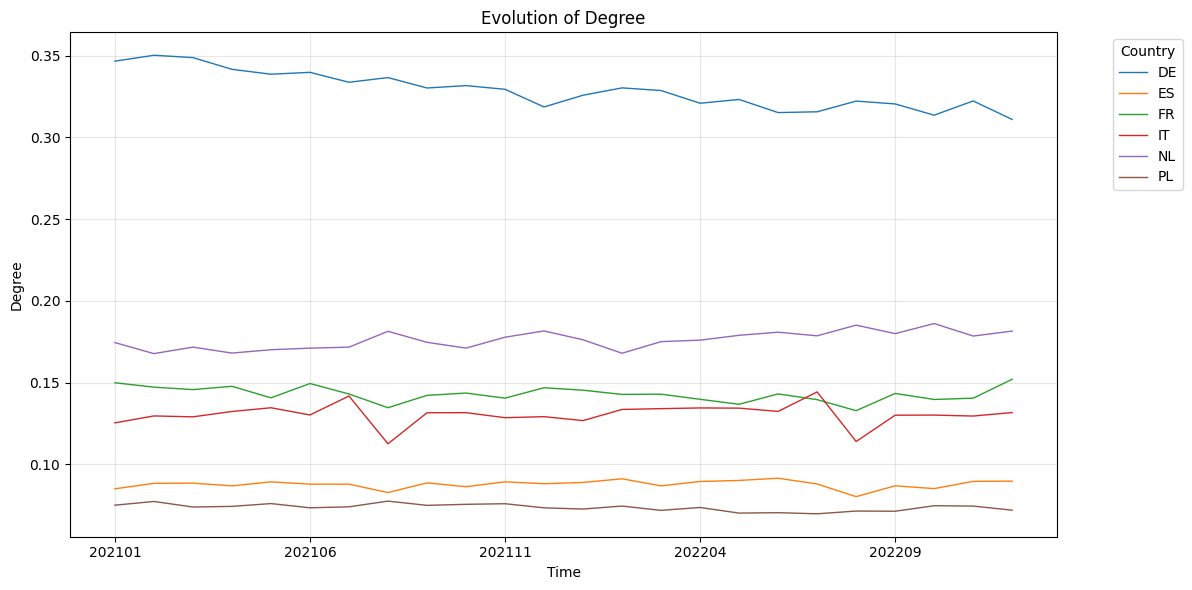

In [16]:
# Select the graph metric to analyse
# Available indicators include:
# 'density', 'degree', 'in_degree', 'out_degree',
# 'closeness', 'betweenness', 'vulnerability', 'distinctiveness'
METRIC = "degree"

# Pivot the dataset to time x country format
df_pivot = (
    df_filtered
    .pivot(index="period", columns="country", values=METRIC)
    .sort_index()
)

# Plot all time series
ax = df_pivot.plot(
    figsize=(12, 6),
    linewidth=1,
    legend=False
)

ax.set_title(f"Evolution of {METRIC.replace('_', ' ').title()}")
ax.set_xlabel("Time")
ax.set_ylabel(METRIC.replace("_", " ").title())
ax.grid(True, alpha=0.3)

plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
df_country_metrics = df_metrics[df_metrics["country"]=="DE"]

In [19]:
df_country_metrics.head(12)

,country,density,degree,vulnerability,out_degree,closeness,betweenness,in_degree,distinctiveness,period
5,DE,1.0,0.322225,0.0,0.159120,0.001269,0.142450,0.163105,0.0,202208
5,DE,1.0,0.320487,0.0,0.161724,0.001236,0.178063,0.158763,0.0,202209
5,DE,1.0,0.313621,0.0,0.158634,0.001562,0.142450,0.154987,0.0,202210
5,DE,1.0,0.322311,0.0,0.166077,0.001529,0.195869,0.156234,0.0,202211
5,DE,1.0,0.310992,0.0,0.162502,0.001544,0.106838,0.148490,0.0,202212
5,DE,1.0,0.321947,0.0,0.164378,0.001243,0.142450,0.157569,0.0,202301
5,DE,1.0,0.328325,0.0,0.174345,0.001231,0.178063,0.153980,0.0,202302
5,DE,1.0,0.329340,0.0,0.177450,0.001356,0.148148,0.151890,0.0,202303
5,DE,1.0,0.317959,0.0,0.167425,0.001283,0.142450,0.150533,0.0,202304
5,DE,1.0,0.319751,0.0,0.167768,0.001352,0.142450,0.151983,0.0,202305


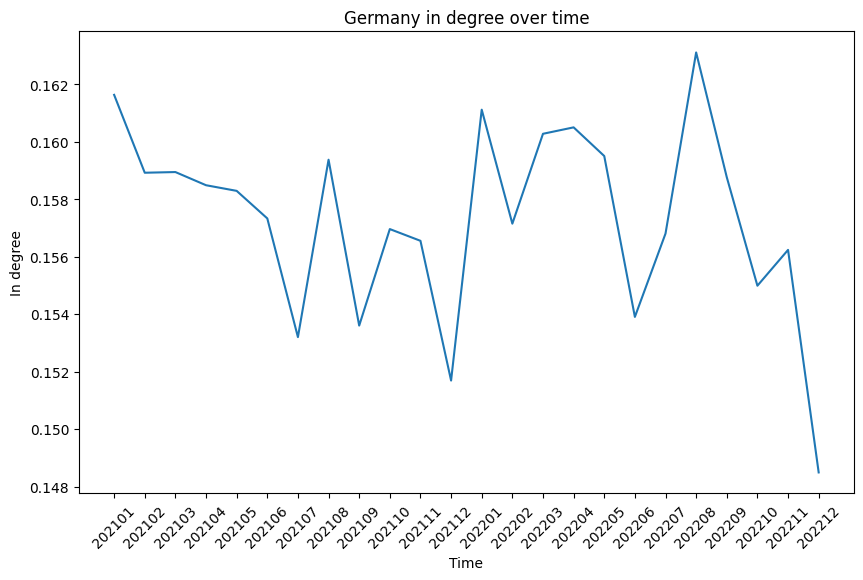

In [19]:
plt.figure(figsize=(10,6))
plt.plot(df_country_metrics["period"], df_country_metrics["in_degree"])
plt.title('Germany in degree over time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('In degree')
plt.show()

## Focus on a single country

In this final example, the temporal evolution of a selected graph metric is
analysed for a single country. This type of analysis is useful to investigate
country-specific dynamics that may be less visible in multi-country plots.


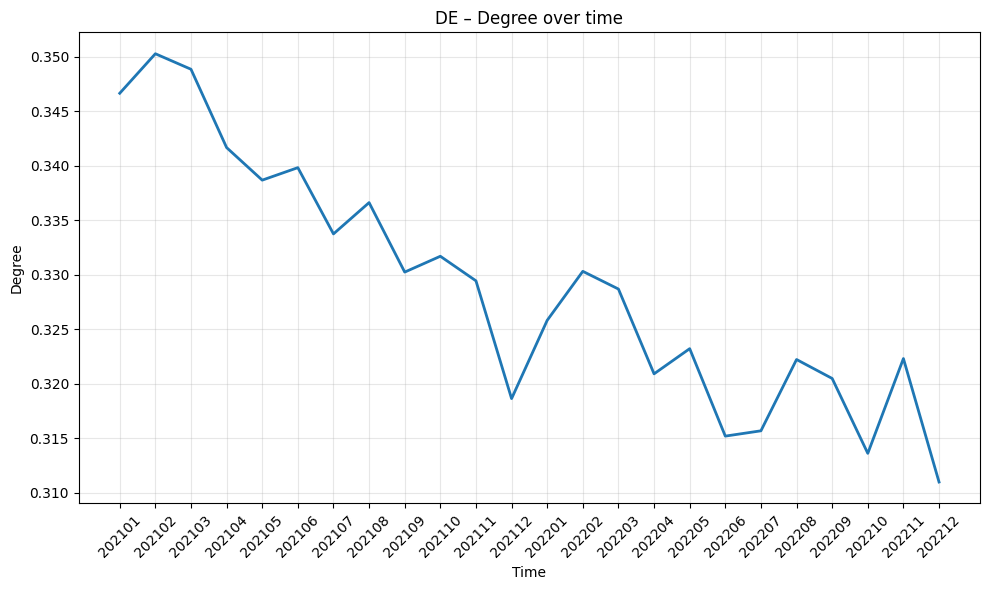

In [21]:
# Select country and metric
COUNTRY = "DE"

# Select the graph metric to analyse
# Available indicators include:
# 'density', 'degree', 'in_degree', 'out_degree',
# 'closeness', 'betweenness', 'vulnerability', 'distinctiveness'
METRIC = "degree"

# Filter data for the selected country
df_country_metrics = (
    df_metrics[df_metrics["country"] == COUNTRY]
    .sort_values("period")
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    df_country_metrics["period"],
    df_country_metrics[METRIC],
    linewidth=2
)

plt.title(
    f"{COUNTRY} – {METRIC.replace('_', ' ').title()} over time"
)
plt.xlabel("Time")
plt.xticks(rotation=45)

plt.ylabel(METRIC.replace("_", " ").title())
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
